In [1]:
# library provided by EPOCH for reading .sdf output files into Python
import sdf_helper as sh
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

In [2]:
# home-grown module
import utilities as util

In [3]:
# show plots in the notebook
%matplotlib inline

In [4]:
fname = '3d.sdf'
data_3d = sh.getdata(fname, verbose=False);

In [5]:
# look at all the data stored in the .sdf file
sh.list_variables(data_3d)

CPU_split_N <class 'sdf.BlockPlainVariable'> [129]
CPU_split_N1 <class 'sdf.BlockPlainVariable'> [129]
CPU_split_N2 <class 'sdf.BlockPlainVariable'> [129]
CPU_split_N_ele <class 'sdf.BlockPlainVariable'> [129]
CPU_split_ele <class 'sdf.BlockPlainVariable'> [129]
CPUs_Current_rank <class 'sdf.BlockPlainVariable'> [0, 0, 0]
CPUs_Original_rank <class 'sdf.BlockPlainVariable'> [32,  2,  2]
Current_Jx <class 'sdf.BlockPlainVariable'> [1024,   64,   64]
Current_Jy <class 'sdf.BlockPlainVariable'> [1024,   64,   64]
Current_Jz <class 'sdf.BlockPlainVariable'> [1024,   64,   64]
Derived_Number_Density_N_ele <class 'sdf.BlockPlainVariable'> [1024,   64,   64]
Derived_Number_Density_ele <class 'sdf.BlockPlainVariable'> [1024,   64,   64]
EPOCH_repository_information <class 'sdf.BlockNameValue'> [6]
Electric_Field_Ex <class 'sdf.BlockPlainVariable'> [1024,   64,   64]
Electric_Field_Ey <class 'sdf.BlockPlainVariable'> [1024,   64,   64]
Electric_Field_Ez <class 'sdf.BlockPlainVariable'> [1024,   

In [6]:
head = data_3d.Header
for k, v in head.items():
    print(k, v)

filename /home/berceanu/Development/PPEx/epoch/old_plotting/3d.sdf
file_version 1
file_revision 4
code_name Epoch3d
step 37467
time 4.269666452553187e-12
jobid1 1457336554
jobid2 924
code_io_version 1
restart_flag True
other_domains False
station_file False


In [7]:
# normalization factor
norm = 2.73092449e-22

In [8]:
# N_ele are the accelerated electrons, from the Nitrogen K-shell
# particle momenta
px = data_3d.Particles_Px_N_ele.data / norm
py = data_3d.Particles_Py_N_ele.data / norm
pz = data_3d.Particles_Pz_N_ele.data / norm
# particle weights
w = data_3d.Particles_Weight_N_ele.data
# particle positions
(x, y, z) = data_3d.Grid_Particles_N_ele.data

In [9]:
# get the grid
(xx, yy, zz) = data_3d.Grid_Grid_mid.data
# get bounds
xx_min = xx.min()
xx_max = xx.max()
yy_min = yy.min()
yy_max = yy.max()
zz_min = zz.min()
zz_max = zz.max()

In [10]:
mask = ((px > 2.) & ((py**2 + pz**2) / px**2 < 1.))
px, py, pz, w, x, y, z = [arr[mask] for arr in (px, py, pz, w, x, y, z)]

In [11]:
ene = .511 * (np.sqrt(1. + px**2 + py**2 + pz**2) - 1.)

In [12]:
H, edges = np.histogramdd(ene, bins=100, weights=w)

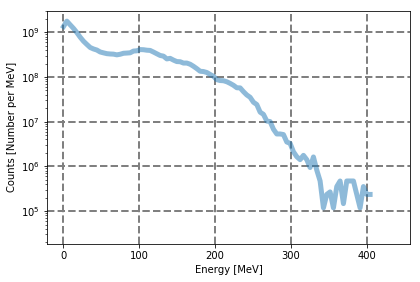

In [13]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
plot_kwds={'linewidth':5, 'alpha':0.5}
ax.semilogy(edges[0][:-1], H, basey=10, nonposy='mask', **plot_kwds)
ax.grid(color='gray', linestyle='--', linewidth=2)
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Counts [Number per MeV]');


In [14]:
angle = np.sqrt(py**2 + pz**2) / px

In [15]:
H, edges = np.histogramdd(angle, bins=80, weights=w)

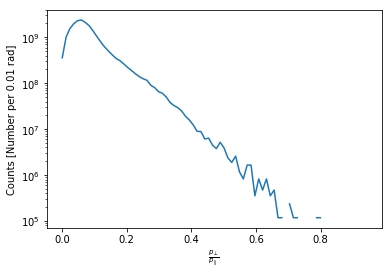

In [16]:
fig, ax = plt.subplots()
ax.semilogy(edges[0][:-1], H, basey=10, nonposy='mask')

ax.set_xlabel(r'$\frac{p_{\perp}}{p_{\parallel}}$')
ax.set_ylabel('Counts [Number per 0.01 rad]');

In [17]:
pperp = np.sqrt(py**2 + pz**2)

In [18]:
H, edges = np.histogramdd([px, pperp], bins=100, weights=w)

In [19]:
# replace zero values before taking the logarithm 
H[~(H > 0.)] = 1.

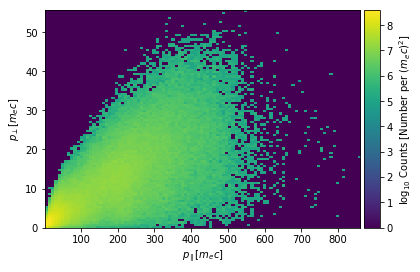

In [20]:
fig, ax = plt.subplots()
img = ax.imshow(np.log10(H.T), origin='lower', interpolation='none',
                extent=np.array([edges[0].min(), edges[0].max(), edges[1].min(), edges[1].max()]),
                aspect='auto')
 
ax.set_xlabel(r'$p_{\parallel} [m_e c]$')
ax.set_ylabel(r'$p_{\perp} [m_e c]$')

cbar = util.colorbar(img)
cbar.set_label(r'$\log_{10}$' + ' Counts [Number per ' + r'$(m_e c)^2]$')

In [21]:
H, edges = np.histogramdd([x, px], bins=100, weights=w)

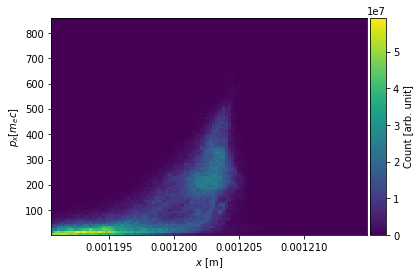

In [22]:
fig, ax = plt.subplots()
img = ax.imshow(H.T, origin='lower', interpolation='none',
                extent=np.array([edges[0].min(), edges[0].max(), edges[1].min(), edges[1].max()]),
                aspect='auto')
 
ax.set_xlabel(r'$x$' + ' [m]')
ax.set_ylabel(r'$p_x [m_e c]$')

cbar = util.colorbar(img)
cbar.set_label('Count [arb. unit]')

In [23]:
def charge_ene_vs_x_3D_N(files):
    # normalization factor
    norm = 2.73092449e-22
    
    x_at_ene_max = list()
    ene_max = list()
    charge = list()
    
    for _, fname in files.items():
        print('processing {}'.format(fname))
        
        d = sh.getdata(fname, verbose=False)
        
        px = d.Particles_Px_N_ele.data / norm
        py = d.Particles_Py_N_ele.data / norm
        pz = d.Particles_Pz_N_ele.data / norm
        w = d.Particles_Weight_N_ele.data
        (x, _, _) = d.Grid_Particles_N_ele.data
        
        mask = (px > 30.)
        px, py, pz, w, x = [arr[mask] for arr in (px, py, pz, w, x)]
        
        ene = .511 * (np.sqrt(1. + px**2 + py**2 + pz**2) - 1.)
        
        charge.append(np.sum(w) * 1.6e-19)
        ene_max.append(np.max(ene))
        x_at_ene_max.append(x[np.argmax(ene)])

    return x_at_ene_max, ene_max, charge

In [24]:
#t = get_sdf_files(rf)
t = OrderedDict([(5, '0005.sdf'),
                 (9, '0009.sdf')])

In [25]:
x_at_ene_max, ene_max, charge = charge_ene_vs_x_3D_N(t)

processing 0005.sdf
processing 0009.sdf


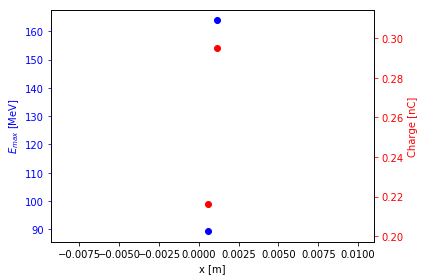

In [26]:
fig, ax1 = plt.subplots()

#left
ax1.scatter(x_at_ene_max, ene_max, c='b')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'$E_{max}$ [MeV]', color='b')
ax1.set_xlabel('x [m]')
ax1.tick_params('y', colors='b')

#right
ax2 = ax1.twinx()
ax2.scatter(x_at_ene_max, np.array(charge)*1e9, c='r')
ax2.set_ylabel('Charge [nC]', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

In [27]:
charge[0] * 1e+9

0.21633584177467899

In [28]:
# load the electric field components
ex = data_3d.Electric_Field_Ex
ey = data_3d.Electric_Field_Ey
ez = data_3d.Electric_Field_Ez

In [29]:
# load the K-shell Nitrogen electrons
nNele = data_3d.Derived_Number_Density_N_ele
rho = nNele.data